In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report,
    roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# --- Data Loading ---

In [ ]:
data = pd.read_csv('diabetes_prediction_dataset.csv')

print(data.head())


# --- Data Preprocessing ---
# Encode categorical variables

In [ ]:
le = LabelEncoder()

data['gender'] = le.fit_transform(data['gender'])

data['smoking_history'] = le.fit_transform(data['smoking_history'])

print(data.head())


# Data Cleaning

In [ ]:
data['smoking_history'] = data['smoking_history'].replace(2, np.nan)

data = data.dropna()

print(data.isnull().sum())


# Feature Scaling

In [ ]:
scaler = StandardScaler()
X = data.drop('diabetes', axis=1)
y = data['diabetes']

X_scaled = scaler.fit_transform(X)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# --- Feature Selection (Optional) ---

In [ ]:
selector = SelectKBest(score_func=f_classif, k='all')  # Or set k to desired number of features
X_selected = selector.fit_transform(X_scaled, y)

# --- Train-Test Split ---

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# --- Model Comparison with Cross-Validation ---

In [ ]:
# model = LogisticRegression(solver='liblinear')
# model.fit(X_train, y_train)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier( eval_metric='logloss', random_state=42)
}

print("Model Comparison (5-fold Cross-Validation):")
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")


Random Forest: 0.9708 ± 0.0010


c:\Users\asus\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:24:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\asus\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:24:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\asus\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:24:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\asus\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:24:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

XGBoost: 0.9721 ± 0.0015


# --- Final Model Training and Evaluation (using best model, e.g., RandomForest) ---

In [22]:
# y_pred = model.predict(X_test)

# conf_matrix = confusion_matrix(y_test, y_pred)

# plt.figure(figsize=(8,6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# plt.title("Confusion Matrix")
# plt.ylabel('Actual Label')
# plt.xlabel('Predicted Label')
# plt.show()

# print("Classification Report:\n", classification_report(y_test, y_pred))
# print("Accuracy: ", accuracy_score(y_test, y_pred))

final_model = XGBClassifier(eval_metric='logloss', random_state=42)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Test Accuracy: 0.9703645833333333

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     17563
           1       0.95      0.69      0.80      1637

    accuracy                           0.97     19200
   macro avg       0.96      0.84      0.89     19200
weighted avg       0.97      0.97      0.97     19200


Confusion Matrix:
 [[17502    61]
 [  508  1129]]


# --- Confusion Matrix Heatmap ---

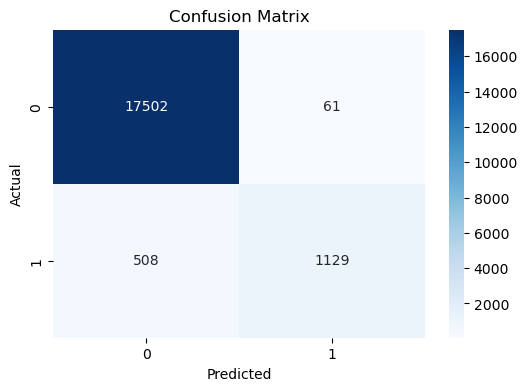

In [23]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- ROC Curve and AUC ---

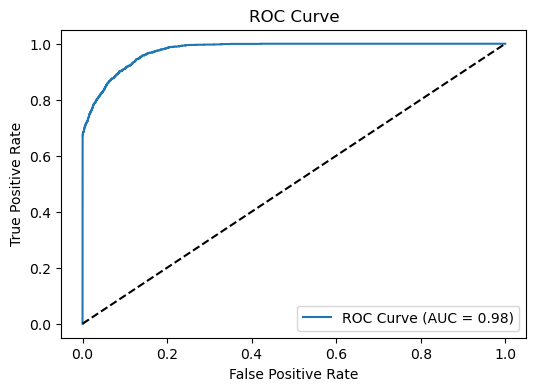

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# --- Forecast Graph (Actual vs Predicted) ---

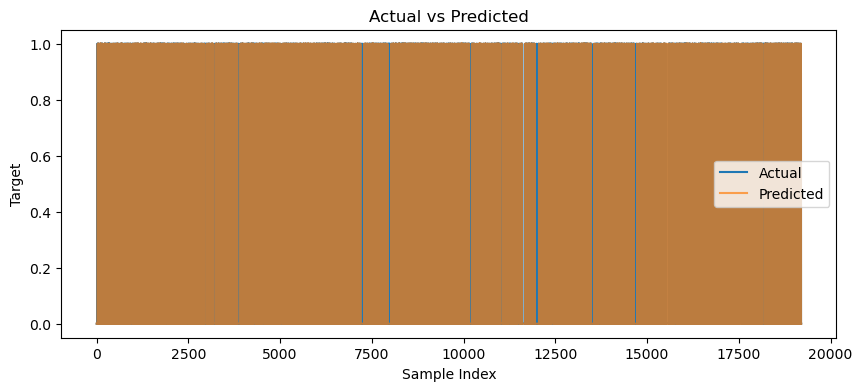

In [25]:
plt.figure(figsize=(10,4))
plt.plot(range(len(y_test)), y_test.values, label='Actual')
plt.plot(range(len(y_pred)), y_pred, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Target')
plt.legend()
plt.show()

# --- Save Model (Optional) ---

In [26]:
# with open('diabetes_model.pkl', 'wb') as file:
#     pickle.dump(model, file)
with open('final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)